In [1]:
import pandas as pd
import sklearn
import re, numpy as np, tensorflow as tf
from keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
# ground truth is 95 bounces.

from numpy.random import seed
seed(10)
tf.random.set_seed(10)

df = pd.read_csv("model2_inputdata.csv", header=None)
df.columns = ['file_name', 'top_left_x', 'top_left_y', 'width', 'height']

In [3]:
df.head()

,file_name,top_left_x,top_left_y,width,height
0,image1.txt,0.4216,0.4996,0.0091,0.0148
1,image2.txt,0.4233,0.4812,0.0083,0.0158
2,image3.txt,0.4249,0.4632,0.0088,0.0148
3,image4.txt,0.4259,0.4551,0.0096,0.0149
4,image5.txt,0.4277,0.4402,0.0094,0.0148


In [4]:
def id_extractor(image_name):
    return int(re.findall('\d+', image_name)[0])

In [5]:
df['image_id'] = df['file_name'].apply(id_extractor)
df['label'] = 0
print(df.shape)

(5200, 7)


In [6]:
df.head()

,file_name,top_left_x,top_left_y,width,height,image_id,label
0,image1.txt,0.4216,0.4996,0.0091,0.0148,1,0
1,image2.txt,0.4233,0.4812,0.0083,0.0158,2,0
2,image3.txt,0.4249,0.4632,0.0088,0.0148,3,0
3,image4.txt,0.4259,0.4551,0.0096,0.0149,4,0
4,image5.txt,0.4277,0.4402,0.0094,0.0148,5,0


In [7]:
ground_truth_bounce_frames = [36, 85, 126, 178, 415, 466, 504, 553, 592, 668, 947, 1000, 1054, 1135, 1312, 1557, 1600,
                              1651, 1721, 1973, 2016, 2052, 2095, 2140, 2180, 2221, 2269, 2315, 2354, 2399, 2442, 2493,
                              2535, 2574, 2615, 2658, 2700, 2738, 2774, 2825, 2862, 3080, 3115, 3164, 3202,
                              3249, 3311, 3373, 3416, 3697, 3742, 3787, 3828, 3873, 3907, 3954, 3986, 4227, 4277, 4318,
                              4361, 4402, 4446, 4499, 4531, 4580, 4610, 4673, 4732, 4767, 4801, 4846, 4890, 4931, 4964,
                              5024, 5241, 5283, 5325, 5366, 5406, 5442, 5493, 5532, 5568, 5610, 5646, 5735, 5788, 5852,
                              6201, 6248, 6286, 6350, 6413, 6671, 6770, 6807, 6867, 7066, 7113]

def labeller(col_value):
    if col_value in ground_truth_bounce_frames:
        return 1
    else:
        return 0


df['label'] = df['image_id'].apply(labeller)
df = df.reset_index(drop=True)

df['centroid_x'] = df['top_left_x'] + df['width'] / 2
df['centroid_y'] = df['top_left_y'] + df['height'] / 2
df = df.drop(columns=['file_name', 'top_left_x', 'top_left_y', 'width', 'height'])

In [8]:
def windowing(window_size:int)->pd.DataFrame:
    X_train = []
    y_train = []
    window = 25
    """
    valid means window is continous. invalid window is [image1,2,3,4,5,75,76,77,78,79] 
    window 10 --> 3247 sliding valid windows
    window 20 --> 2222 sliding valid windows
    window 30 --> 1589 sliding valid windows
    window 40 --> 1124 sliding valid windows
    window 50 --> 816 sliding valid windows
    window 60 --> 615 sliding valid windows
    """

    for start in range(len(df) - window):
        window_end = df['image_id'][start + window - 1]
        window_end_max = df['image_id'][start] + window - 1
        if window_end <= window_end_max:
            X_train.append(df[['centroid_x', 'centroid_y']][start:start + window])
            y_train.append(np.max(df['label'][start:start + window], axis=0))

    X_train = np.array(X_train)
    y_train = np.array(y_train).reshape(len(y_train), 1)
    bounce_no = len([0 for i in y_train if i == 0])
    bounce_yes = len([0 for i in y_train if i == 1])
    print('If window = {}, {} % windows have bounce'.format(window, np.round(bounce_yes*100/len(y_train),3)))
    return X_train,y_train

In [9]:
X_train,y_train = windowing(20)

If window = 25, 47.741 % windows have bounce


In [10]:
####################################################################
#                          Modeling                                #
####################################################################

model = Sequential()
model.add(SimpleRNN(32, activation='relu', input_shape=(X_train.shape[1], 
                                                                 X_train.shape[2]), return_sequences=True))
model.add(SimpleRNN(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics = [tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

#model.summary()


2022-04-22 02:15:21.548730: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
42/42 [==============================] - 3s 24ms/step - loss: 0.6883 - auc: 0.5678 - precision: 0.5714 - recall: 0.6571 - val_loss: 0.7855 - val_auc: 0.4004 - val_precision: 0.3185 - val_recall: 0.7222
Epoch 2/100
42/42 [==============================] - 0s 11ms/step - loss: 0.6270 - auc: 0.7107 - precision: 0.6801 - recall: 0.6771 - val_loss: 0.7739 - val_auc: 0.5771 - val_precision: 0.3825 - val_recall: 0.9040
Epoch 3/100
42/42 [==============================] - 0s 11ms/step - loss: 0.5780 - auc: 0.7702 - precision: 0.6695 - recall: 0.7843 - val_loss: 0.6140 - val_auc: 0.6696 - val_precision: 0.4718 - val_recall: 0.4646
Epoch 4/100
42/42 [==============================] - 0s 11ms/step - loss: 0.5542 - auc: 0.7917 - precision: 0.7166 - recall: 0.7443 - val_loss: 0.7724 - val_auc: 0.6486 - val_precision: 0.4029 - val_recall: 0.8283
Epoch 5/100
42/42 [==============================] - 0s 11ms/step - loss: 0.5029 - auc: 0.8338 - precision: 0.7392 - recall: 0.7857 - val_loss: 

42/42 [==============================] - 0s 10ms/step - loss: 0.2711 - auc: 0.9549 - precision: 0.9003 - recall: 0.8771 - val_loss: 0.6690 - val_auc: 0.7786 - val_precision: 0.5513 - val_recall: 0.7323
Epoch 40/100
42/42 [==============================] - 0s 10ms/step - loss: 0.2791 - auc: 0.9513 - precision: 0.8921 - recall: 0.8743 - val_loss: 0.5236 - val_auc: 0.8423 - val_precision: 0.6624 - val_recall: 0.7929
Epoch 41/100
42/42 [==============================] - 0s 10ms/step - loss: 0.2917 - auc: 0.9473 - precision: 0.8881 - recall: 0.8729 - val_loss: 0.5580 - val_auc: 0.8366 - val_precision: 0.6240 - val_recall: 0.8131
Epoch 42/100
42/42 [==============================] - 0s 10ms/step - loss: 0.2548 - auc: 0.9601 - precision: 0.9131 - recall: 0.8857 - val_loss: 0.6564 - val_auc: 0.8347 - val_precision: 0.5867 - val_recall: 0.8889
Epoch 43/100
42/42 [==============================] - 0s 10ms/step - loss: 0.2595 - auc: 0.9587 - precision: 0.9121 - recall: 0.8743 - val_loss: 0.7396 -

42/42 [==============================] - 0s 10ms/step - loss: 0.1596 - auc: 0.9843 - precision: 0.9450 - recall: 0.9329 - val_loss: 0.8007 - val_auc: 0.7899 - val_precision: 0.5857 - val_recall: 0.7424
Epoch 78/100
42/42 [==============================] - 0s 10ms/step - loss: 0.1801 - auc: 0.9798 - precision: 0.9359 - recall: 0.9171 - val_loss: 0.8485 - val_auc: 0.7711 - val_precision: 0.5708 - val_recall: 0.6717
Epoch 79/100
42/42 [==============================] - 0s 10ms/step - loss: 0.2084 - auc: 0.9727 - precision: 0.9271 - recall: 0.9086 - val_loss: 0.8082 - val_auc: 0.7989 - val_precision: 0.5699 - val_recall: 0.8030
Epoch 80/100
42/42 [==============================] - 0s 10ms/step - loss: 0.1726 - auc: 0.9815 - precision: 0.9393 - recall: 0.9286 - val_loss: 0.8159 - val_auc: 0.7818 - val_precision: 0.5650 - val_recall: 0.6364
Epoch 81/100
42/42 [==============================] - 0s 10ms/step - loss: 0.1657 - auc: 0.9833 - precision: 0.9398 - recall: 0.9371 - val_loss: 0.7191 -

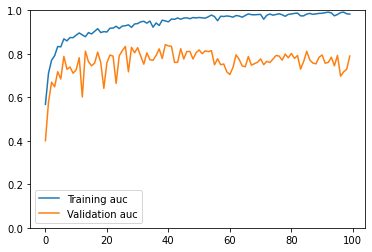

In [11]:
# fit the model
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_auc', patience=3, verbose=1)
callbacks_list = [early_stopping]
# history = model.fit(X_train, y_train, epochs=500, validation_split= 0.2,verbose=1,
#                     batch_size = 16, callbacks=[callbacks_list]);
history = model.fit(X_train, y_train, epochs=100, validation_split= 0.3,verbose=1);

plt.plot(history.history['auc'], label='Training auc')
plt.plot(history.history['val_auc'], label='Validation auc')
plt.ylim([0.0, 1.0])
plt.legend()



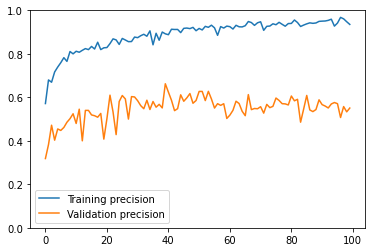

In [12]:
plt.plot(history.history['precision'], label='Training precision')
plt.plot(history.history['val_precision'], label='Validation precision')
plt.ylim([0.0, 1.0])
plt.legend()

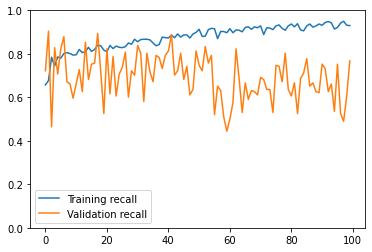

In [13]:
plt.plot(history.history['recall'], label='Training recall')
plt.plot(history.history['val_recall'], label='Validation recall')
plt.ylim([0.0, 1.0])
plt.legend()